# MLP
Like MLP_269 but run on every cell line individually.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-19 17:58:16.245721


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
# EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_269'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    ordered_list = ['HT1080']  # special case
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    string = fields[cell_line]
                    if string != 'nan':
                        value = float(string)
                        self.gene2rci[gene_id] = value
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-19 17:58:50.760382
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd)  # no validation )
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

In [11]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)




2023-04-19 17:58:52.092759
Cell Line 0 HT1080
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1630
Num RCI: 1630
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 1630 sequences.

Training # 1 1
2023-04-19 17:59:00.057980
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-19 17:59:00.276545
Discriminator is GMM
Means [-2.105863623919438, 0.3684779277094723]
Variances [1.32098869 1.13953323]
Priors [0.36160559 0.63839441]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 860:431 66.62%
Computed class weights: {0: 1.4976798143851509, 1: 0.7505813953488372}
Valid 1:0 222:117 65.49%
FIT
2023-04-19 17:59:01.278977


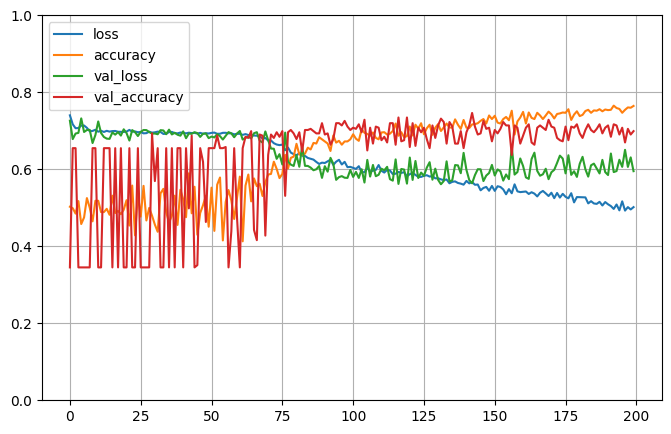


Testing # 1 1
2023-04-19 18:00:25.086585
2023-04-19 18:00:25.086662
PREDICT
2023-04-19 18:00:25.092433
Test 1:0 222:117 65.49%
Predict 1:0 244:95 71.98%
Test sizes (339, 1025) (339,)
Distrib of scores: 0.63358116 mean 0.26458466 std
Range of scores: 0.01752662 to 0.9770134
Score threshold 0.5
Confusion matrix
 [[ 55  62]
 [ 40 182]]
Normalized matrix
 [[0.16224189 0.18289086]
 [0.1179941  0.53687316]]
Extreme scores correct, pos:neg 154 41
Extreme scores incorrect pos:neg 39 21


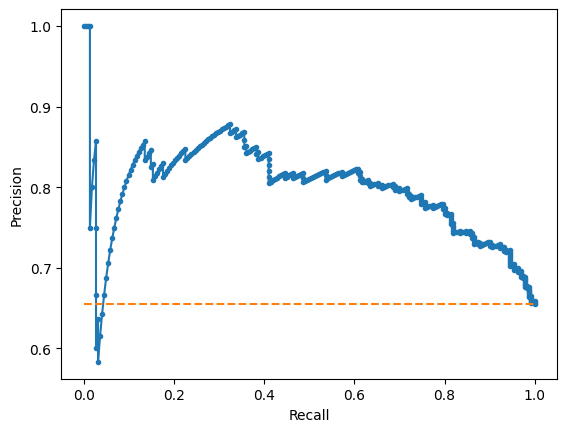

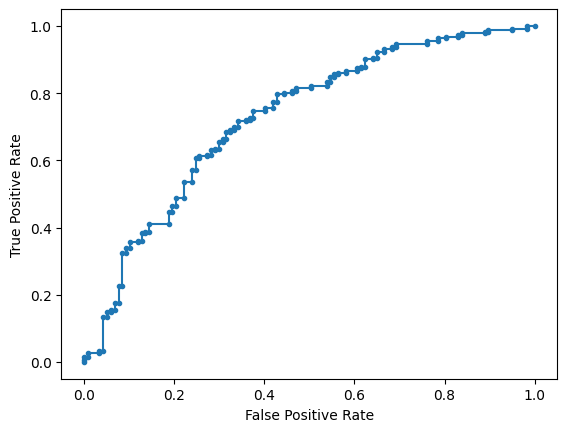

Accuracy: 69.91% Precision: 74.59% Recall: 81.98%
F1: 78.11% MCC: 0.3069
AUPRC: 79.77% AUROC: 72.68%
 accuracy [69.91150442477876]
 precision [74.59016393442623]
 recall [81.98198198198197]
 F1 [78.1115879828326]
 MCC [0.30688018145792567]
 AUPRC [79.77450791356262]
 AUROC [72.67652267652268]

Training # 1 2
2023-04-19 18:00:25.829126
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-19 18:00:26.055812
Discriminator is GMM
Means [0.36783299269220027, -2.0915342663050263]
Variances [1.19886702 1.349206  ]
Priors [0.6260464 0.3739536]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 840:450 65.12%
Computed class weights: {0: 1.4333333333333333, 1: 0.7678571428571429}
Valid 1:0 237:103 69.71%
FIT
2023-04-19 18:00:26.864551


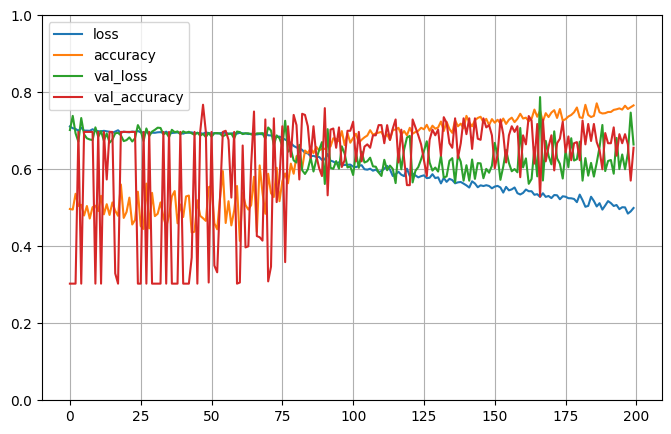


Testing # 1 2
2023-04-19 18:01:37.253160
2023-04-19 18:01:37.253213
PREDICT
2023-04-19 18:01:37.261757
Test 1:0 237:103 69.71%
Predict 1:0 186:154 54.71%
Test sizes (340, 1025) (340,)
Distrib of scores: 0.5184957 mean 0.25712436 std
Range of scores: 0.015085666 to 0.9735812
Score threshold 0.5
Confusion matrix
 [[ 70  33]
 [ 84 153]]
Normalized matrix
 [[0.20588235 0.09705882]
 [0.24705882 0.45      ]]
Extreme scores correct, pos:neg 99 52
Extreme scores incorrect pos:neg 23 47


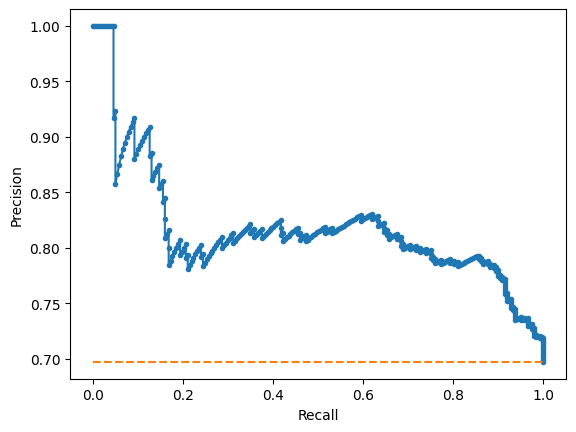

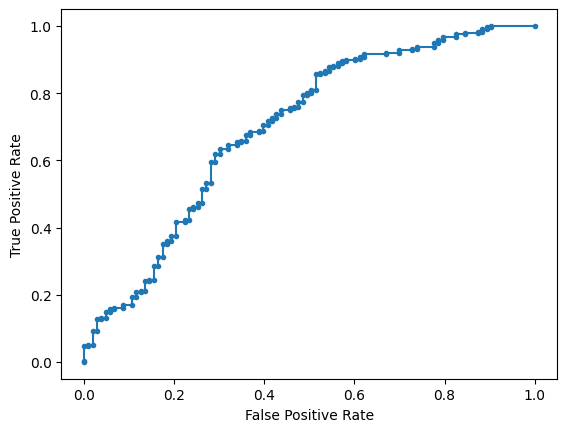

Accuracy: 65.59% Precision: 82.26% Recall: 64.56%
F1: 72.34% MCC: 0.3002
AUPRC: 81.70% AUROC: 69.88%
 accuracy [65.58823529411765]
 precision [82.25806451612904]
 recall [64.55696202531645]
 F1 [72.3404255319149]
 MCC [0.30019363293959395]
 AUPRC [81.70351744258534]
 AUROC [69.87833353815903]

Training # 1 3
2023-04-19 18:01:38.576805
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-19 18:01:38.807462
Discriminator is GMM
Means [-2.1096222893623566, 0.4031662083656714]
Variances [1.44857767 1.20229215]
Priors [0.36164896 0.63835104]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 877:429 67.15%
Computed class weights: {0: 1.5221445221445222, 1: 0.7445838084378563}
Valid 1:0 205:119 63.27%
FIT
2023-04-19 18:01:49.171156


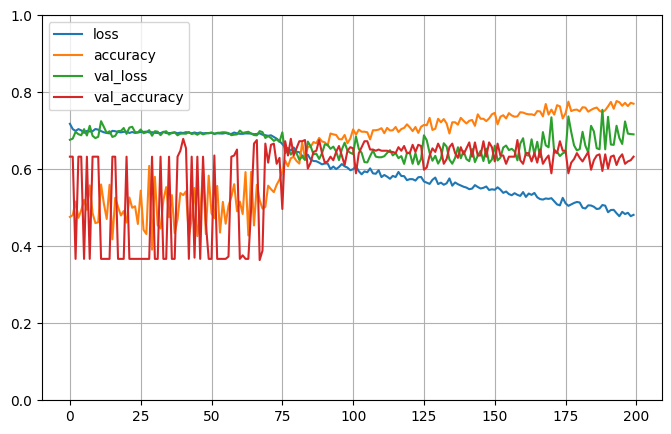


Testing # 1 3
2023-04-19 18:03:14.261335
2023-04-19 18:03:14.261386
PREDICT
2023-04-19 18:03:14.264852
Test 1:0 205:119 63.27%
Predict 1:0 186:138 57.41%
Test sizes (324, 1025) (324,)
Distrib of scores: 0.5460007 mean 0.27946728 std
Range of scores: 0.016154995 to 0.98624146
Score threshold 0.5
Confusion matrix
 [[ 69  50]
 [ 69 136]]
Normalized matrix
 [[0.21296296 0.15432099]
 [0.21296296 0.41975309]]
Extreme scores correct, pos:neg 106 52
Extreme scores incorrect pos:neg 34 45


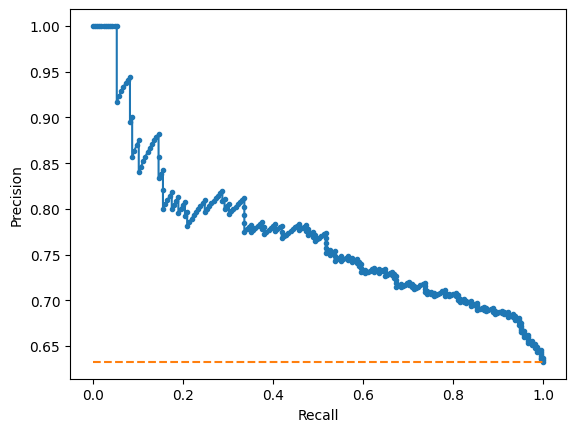

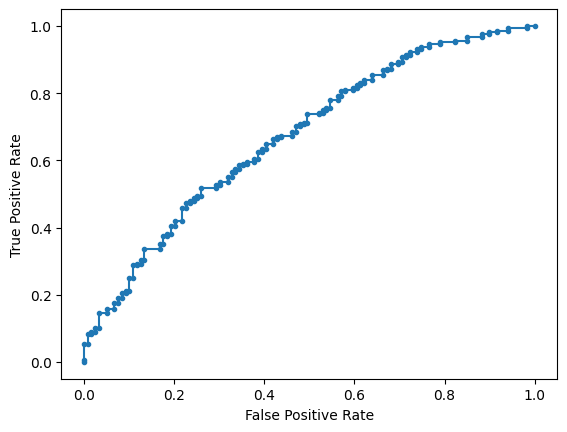

Accuracy: 63.27% Precision: 73.12% Recall: 66.34%
F1: 69.57% MCC: 0.2371
AUPRC: 77.12% AUROC: 67.24%
 accuracy [63.27160493827161]
 precision [73.11827956989248]
 recall [66.34146341463415]
 F1 [69.56521739130436]
 MCC [0.237137979633386]
 AUPRC [77.11839601027842]
 AUROC [67.23918835827014]

Training # 1 4
2023-04-19 18:03:14.923561
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-19 18:03:15.190362
Discriminator is GMM
Means [0.3923633942905085, -2.19796408737681]
Variances [1.21178041 1.33331871]
Priors [0.64234766 0.35765234]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 888:446 66.57%
Computed class weights: {0: 1.4955156950672646, 1: 0.7511261261261262}
Valid 1:0 202:94 68.24%
FIT
2023-04-19 18:03:16.029128


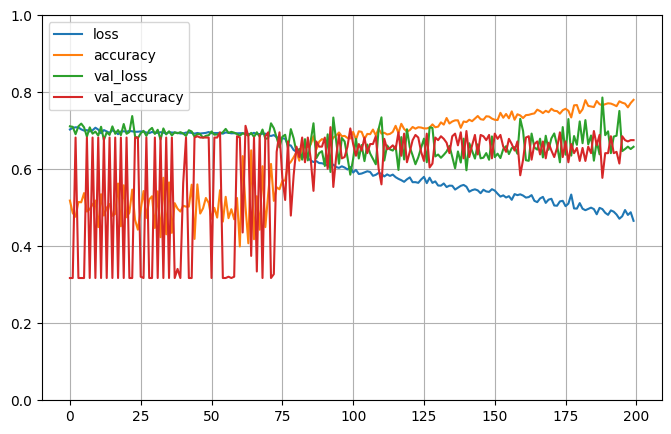


Testing # 1 4
2023-04-19 18:04:20.645156
2023-04-19 18:04:20.645210
PREDICT
2023-04-19 18:04:20.650082
Test 1:0 202:94 68.24%
Predict 1:0 198:98 66.89%
Test sizes (296, 1025) (296,)
Distrib of scores: 0.59957796 mean 0.2725694 std
Range of scores: 0.028351862 to 0.9841043
Score threshold 0.5
Confusion matrix
 [[ 48  46]
 [ 50 152]]
Normalized matrix
 [[0.16216216 0.15540541]
 [0.16891892 0.51351351]]
Extreme scores correct, pos:neg 121 39
Extreme scores incorrect pos:neg 30 31


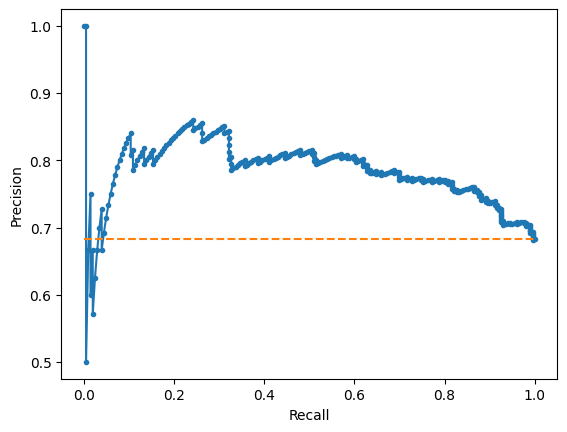

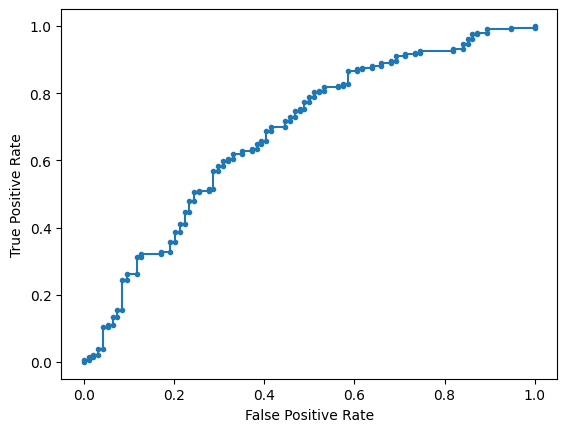

Accuracy: 67.57% Precision: 76.77% Recall: 75.25%
F1: 76.00% MCC: 0.2603
AUPRC: 78.38% AUROC: 68.07%
 accuracy [67.56756756756756]
 precision [76.76767676767676]
 recall [75.24752475247524]
 F1 [76.0]
 MCC [0.26027783476120203]
 AUPRC [78.38259394086369]
 AUROC [68.06930693069306]

Training # 1 5
2023-04-19 18:04:21.278319
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-19 18:04:21.474920
Discriminator is GMM
Means [0.37974337471192793, -2.0613433597723083]
Variances [1.20568796 1.40245621]
Priors [0.62883653 0.37116347]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 858:441 66.05%
Computed class weights: {0: 1.4727891156462585, 1: 0.756993006993007}
Valid 1:0 217:114 65.56%
FIT
2023-04-19 18:04:22.378778


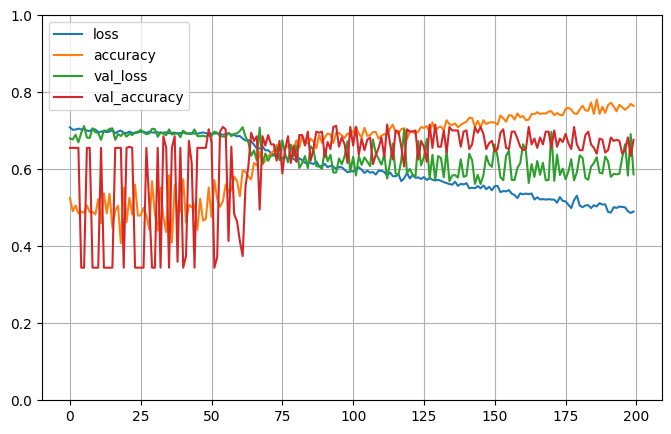


Testing # 1 5
2023-04-19 18:05:28.376517
2023-04-19 18:05:28.376571
PREDICT
2023-04-19 18:05:28.381572
Test 1:0 217:114 65.56%
Predict 1:0 222:109 67.07%
Test sizes (331, 1025) (331,)
Distrib of scores: 0.599366 mean 0.26215887 std
Range of scores: 0.01700619 to 0.98096424
Score threshold 0.5
Confusion matrix
 [[ 58  56]
 [ 51 166]]
Normalized matrix
 [[0.17522659 0.16918429]
 [0.15407855 0.50151057]]
Extreme scores correct, pos:neg 136 43
Extreme scores incorrect pos:neg 38 27


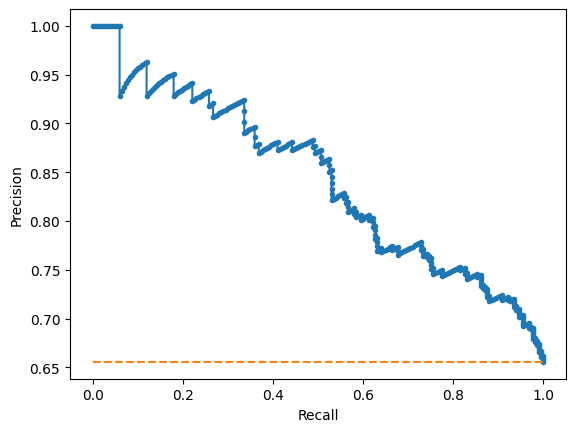

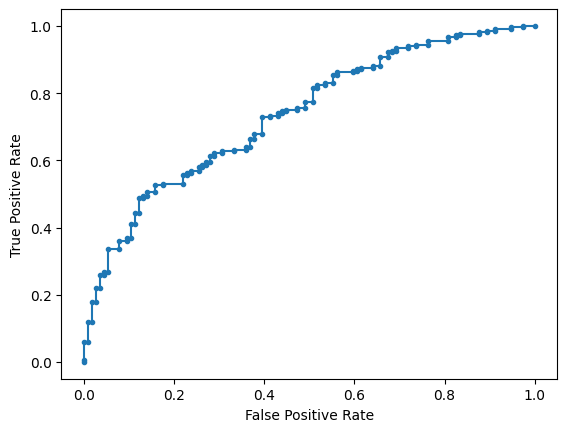

Accuracy: 67.67% Precision: 74.77% Recall: 76.50%
F1: 75.63% MCC: 0.2768
AUPRC: 84.25% AUROC: 73.65%
 accuracy [67.6737160120846]
 precision [74.77477477477478]
 recall [76.49769585253456]
 F1 [75.62642369020503]
 MCC [0.27678651061175574]
 AUPRC [84.25347967665353]
 AUROC [73.64782925054573]

Training # 2 1
2023-04-19 18:05:29.061116
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-19 18:05:29.251235
Discriminator is GMM
Means [0.39137643659331733, -2.0766618078680854]
Variances [1.18868102 1.35479934]
Priors [0.63005504 0.36994496]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 866:449 65.86%
Computed class weights: {0: 1.4643652561247216, 1: 0.7592378752886836}
Valid 1:0 208:107 66.03%
FIT
2023-04-19 18:05:30.066922


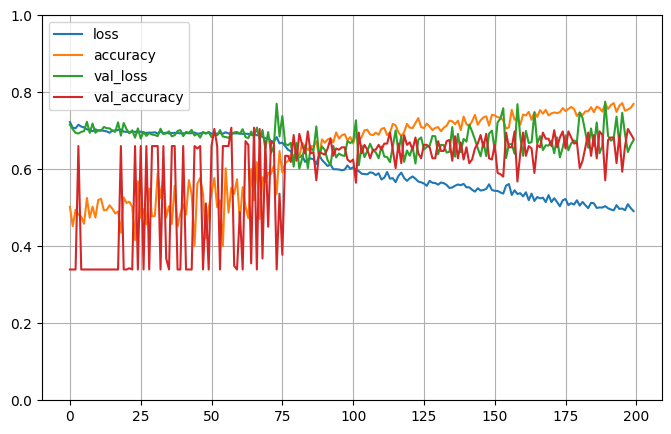


Testing # 2 1
2023-04-19 18:06:53.637978
2023-04-19 18:06:53.638032
PREDICT
2023-04-19 18:06:53.641273
Test 1:0 208:107 66.03%
Predict 1:0 195:120 61.90%
Test sizes (315, 1025) (315,)
Distrib of scores: 0.5566938 mean 0.25808376 std
Range of scores: 0.036169954 to 0.9621929
Score threshold 0.5
Confusion matrix
 [[ 63  44]
 [ 57 151]]
Normalized matrix
 [[0.2        0.13968254]
 [0.18095238 0.47936508]]
Extreme scores correct, pos:neg 104 43
Extreme scores incorrect pos:neg 28 34


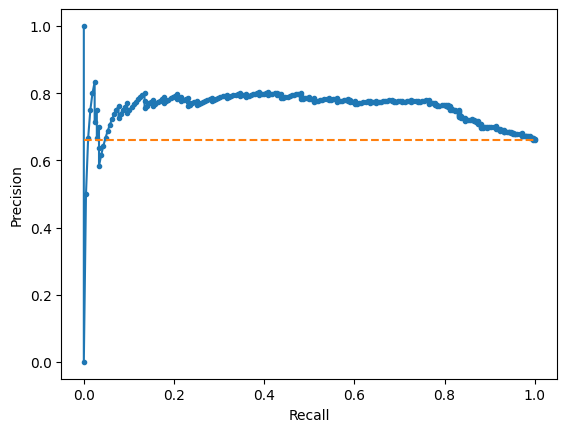

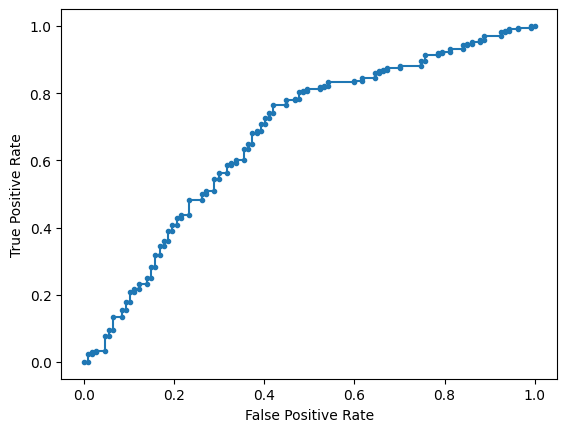

Accuracy: 67.94% Precision: 77.44% Recall: 72.60%
F1: 74.94% MCC: 0.3070
AUPRC: 75.66% AUROC: 67.46%
 accuracy [67.93650793650794]
 precision [77.43589743589745]
 recall [72.59615384615384]
 F1 [74.93796526054591]
 MCC [0.30695637300049783]
 AUPRC [75.6581181649631]
 AUROC [67.46046010064701]

Training # 2 2
2023-04-19 18:06:54.304577
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-19 18:06:54.484233
Discriminator is GMM
Means [0.3752376624337398, -2.105997624754041]
Variances [1.17457024 1.3660453 ]
Priors [0.63620735 0.36379265]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 876:443 66.41%
Computed class weights: {0: 1.4887133182844243, 1: 0.7528538812785388}
Valid 1:0 206:105 66.24%
FIT
2023-04-19 18:06:55.291392


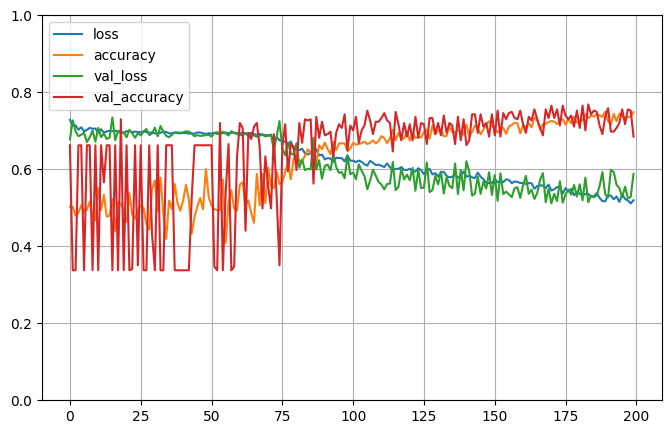


Testing # 2 2
2023-04-19 18:08:00.226710
2023-04-19 18:08:00.229711
PREDICT
2023-04-19 18:08:00.234242
Test 1:0 206:105 66.24%
Predict 1:0 160:151 51.45%
Test sizes (311, 1025) (311,)
Distrib of scores: 0.5008853 mean 0.255698 std
Range of scores: 0.013357436 to 0.9651255
Score threshold 0.5
Confusion matrix
 [[ 79  26]
 [ 72 134]]
Normalized matrix
 [[0.25401929 0.08360129]
 [0.23151125 0.43086817]]
Extreme scores correct, pos:neg 92 62
Extreme scores incorrect pos:neg 14 32


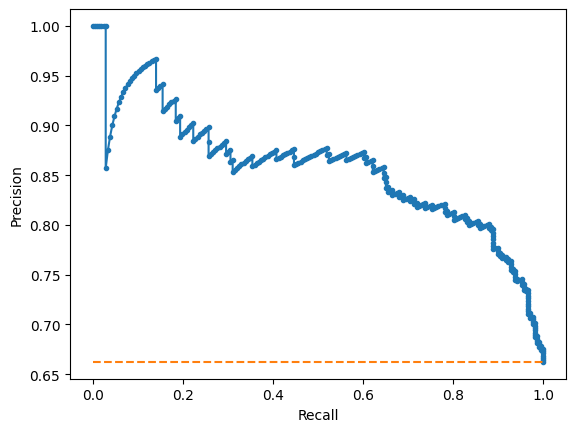

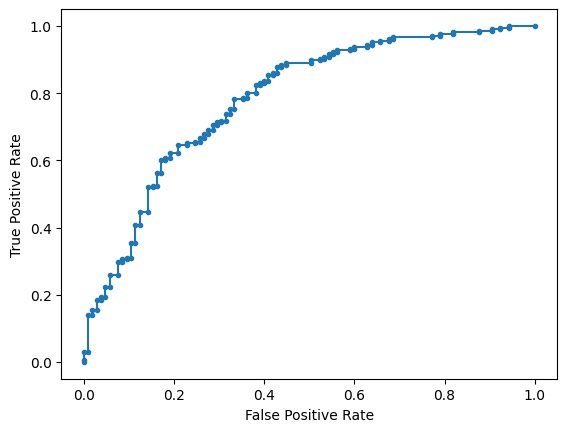

Accuracy: 68.49% Precision: 83.75% Recall: 65.05%
F1: 73.22% MCC: 0.3812
AUPRC: 85.68% AUROC: 78.37%
 accuracy [68.48874598070739]
 precision [83.75]
 recall [65.0485436893204]
 F1 [73.224043715847]
 MCC [0.381189413606048]
 AUPRC [85.67550218521738]
 AUROC [78.36800739713361]

Training # 2 3
2023-04-19 18:08:01.026570
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-19 18:08:01.235991
Discriminator is GMM
Means [0.36092662948346355, -2.112151779319659]
Variances [1.14599482 1.29889027]
Priors [0.62879146 0.37120854]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 845:441 65.71%
Computed class weights: {0: 1.4580498866213152, 1: 0.7609467455621302}
Valid 1:0 234:110 68.02%
FIT
2023-04-19 18:08:02.171321


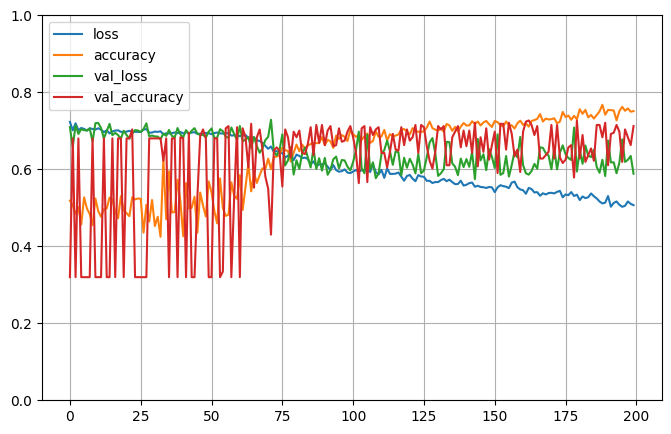


Testing # 2 3
2023-04-19 18:09:25.636912
2023-04-19 18:09:25.636962
PREDICT
2023-04-19 18:09:25.644640
Test 1:0 234:110 68.02%
Predict 1:0 251:93 72.97%
Test sizes (344, 1025) (344,)
Distrib of scores: 0.6342404 mean 0.24017395 std
Range of scores: 0.0679695 to 0.9849856
Score threshold 0.5
Confusion matrix
 [[ 52  58]
 [ 41 193]]
Normalized matrix
 [[0.15116279 0.16860465]
 [0.11918605 0.56104651]]
Extreme scores correct, pos:neg 142 34
Extreme scores incorrect pos:neg 35 20


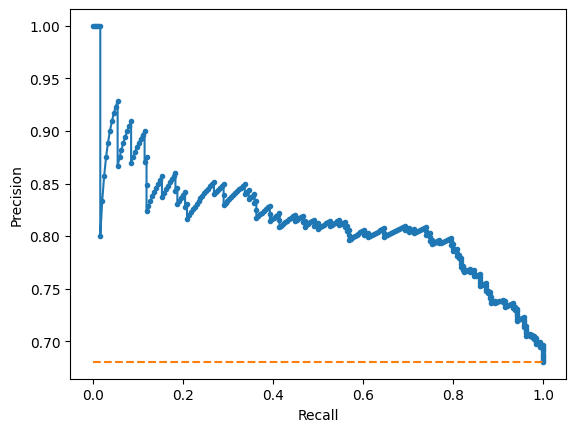

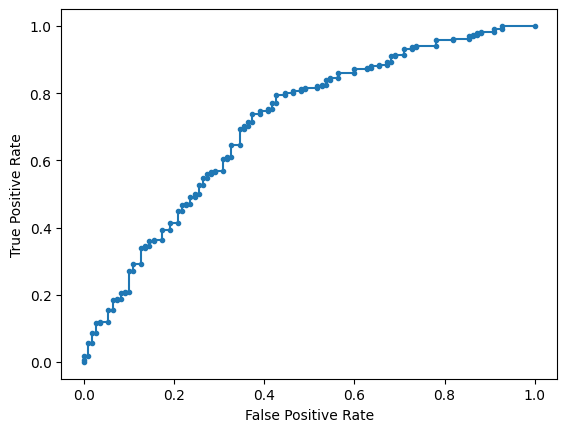

Accuracy: 71.22% Precision: 76.89% Recall: 82.48%
F1: 79.59% MCC: 0.3124
AUPRC: 81.34% AUROC: 70.78%
 accuracy [71.22093023255815]
 precision [76.89243027888446]
 recall [82.47863247863248]
 F1 [79.58762886597938]
 MCC [0.3124156317425242]
 AUPRC [81.33877731809437]
 AUROC [70.78477078477079]

Training # 2 4
2023-04-19 18:09:26.330147
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-19 18:09:26.520489
Discriminator is GMM
Means [0.39626183186209485, -2.1319751278581034]
Variances [1.23538254 1.37859161]
Priors [0.64056503 0.35943497]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 868:430 66.87%
Computed class weights: {0: 1.5093023255813953, 1: 0.7476958525345622}
Valid 1:0 217:115 65.36%
FIT
2023-04-19 18:09:27.409265


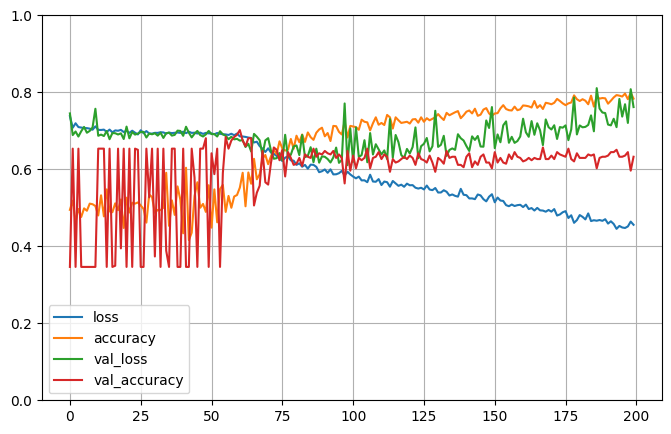


Testing # 2 4
2023-04-19 18:10:32.321259
2023-04-19 18:10:32.321978
PREDICT
2023-04-19 18:10:32.327785
Test 1:0 217:115 65.36%
Predict 1:0 201:131 60.54%
Test sizes (332, 1025) (332,)
Distrib of scores: 0.5473061 mean 0.30149674 std
Range of scores: 0.0054331985 to 0.97440916
Score threshold 0.5
Confusion matrix
 [[ 62  53]
 [ 69 148]]
Normalized matrix
 [[0.18674699 0.15963855]
 [0.20783133 0.44578313]]
Extreme scores correct, pos:neg 112 49
Extreme scores incorrect pos:neg 39 52


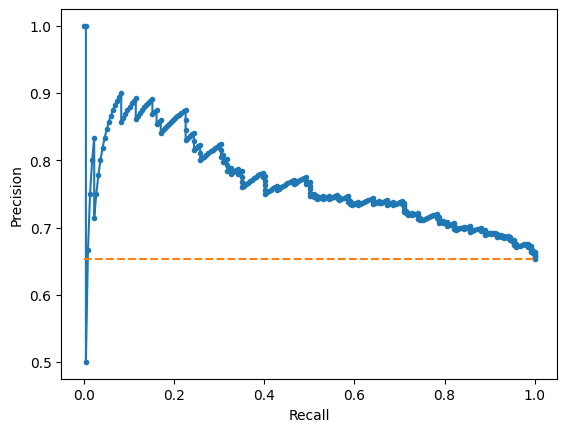

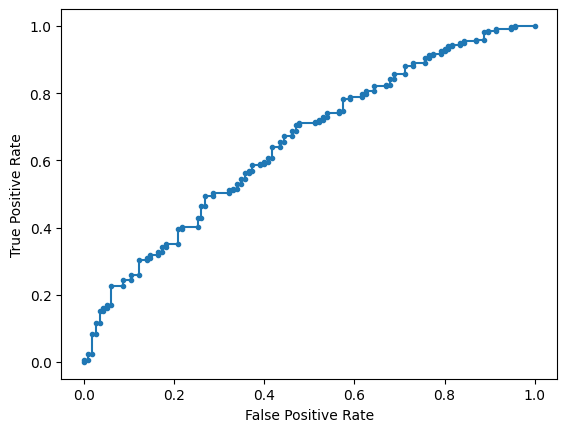

Accuracy: 63.25% Precision: 73.63% Recall: 68.20%
F1: 70.81% MCC: 0.2153
AUPRC: 76.54% AUROC: 65.08%
 accuracy [63.25301204819277]
 precision [73.6318407960199]
 recall [68.20276497695853]
 F1 [70.81339712918661]
 MCC [0.21530193371903542]
 AUPRC [76.54222436159426]
 AUROC [65.07713884992987]

Training # 2 5
2023-04-19 18:10:33.084822
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-19 18:10:33.281811
Discriminator is GMM
Means [-2.165523996559738, 0.3778192700275712]
Variances [1.44016071 1.22112323]
Priors [0.35523757 0.64476243]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 876:426 67.28%
Computed class weights: {0: 1.528169014084507, 1: 0.7431506849315068}
Valid 1:0 218:110 66.46%
FIT
2023-04-19 18:10:34.150843


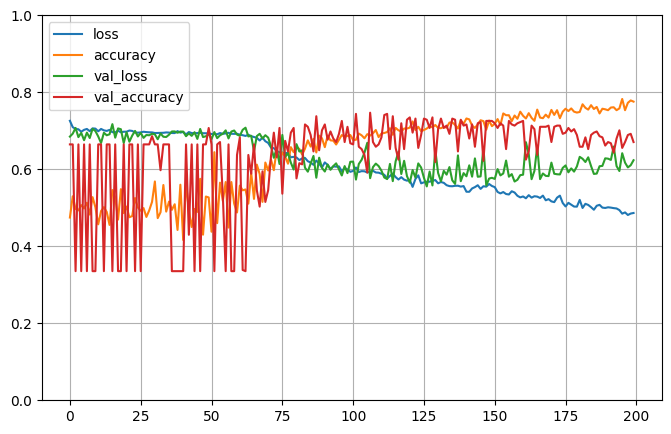


Testing # 2 5
2023-04-19 18:11:36.780384
2023-04-19 18:11:36.780435
PREDICT
2023-04-19 18:11:36.783886
Test 1:0 218:110 66.46%
Predict 1:0 208:120 63.41%
Test sizes (328, 1025) (328,)
Distrib of scores: 0.57805103 mean 0.2718003 std
Range of scores: 0.014696286 to 0.9878427
Score threshold 0.5
Confusion matrix
 [[ 61  49]
 [ 59 159]]
Normalized matrix
 [[0.18597561 0.14939024]
 [0.17987805 0.4847561 ]]
Extreme scores correct, pos:neg 120 46
Extreme scores incorrect pos:neg 27 33


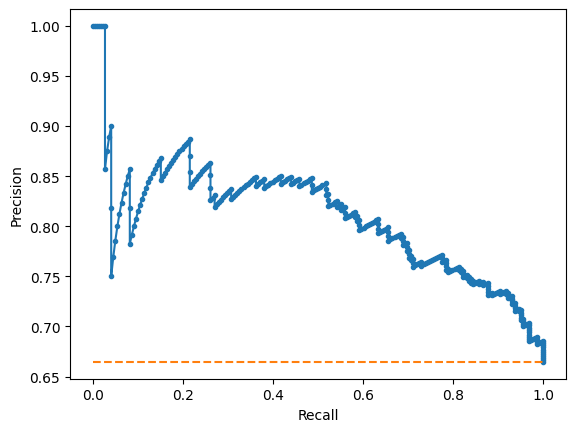

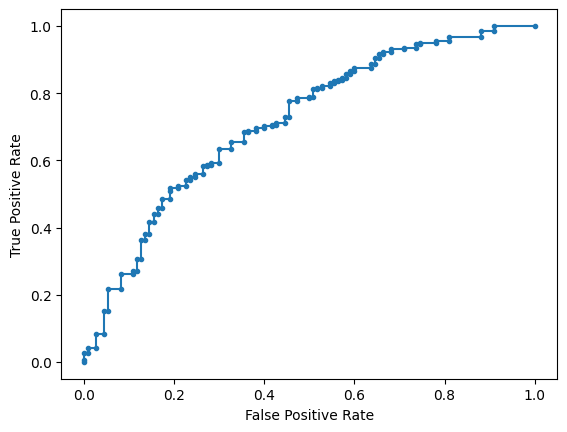

Accuracy: 67.07% Precision: 76.44% Recall: 72.94%
F1: 74.65% MCC: 0.2783
AUPRC: 80.89% AUROC: 71.54%
 accuracy [67.07317073170732]
 precision [76.4423076923077]
 recall [72.93577981651376]
 F1 [74.64788732394366]
 MCC [0.27827402334652007]
 AUPRC [80.89226623645602]
 AUROC [71.54295246038366]
 accuracy mean 67.20% std 2.58
 precision mean 76.97% std 3.51
 recall mean 72.59% std 6.57
 F1 mean 74.49% std 3.11
 MCC mean 0.2875 std 0.0460
 AUPRC mean 80.13% std 3.29
 AUROC mean 70.47% std 3.85
 accuracy [[69.91150442477876], [65.58823529411765], [63.27160493827161], [67.56756756756756], [67.6737160120846], [67.93650793650794], [68.48874598070739], [71.22093023255815], [63.25301204819277], [67.07317073170732]]
 precision [[74.59016393442623], [82.25806451612904], [73.11827956989248], [76.76767676767676], [74.77477477477478], [77.43589743589745], [83.75], [76.89243027888446], [73.6318407960199], [76.4423076923077]]
 recall [[81.98198198198197], [64.55696202531645], [66.34146341463415], [75.2

In [12]:
for cell_line in range(len(all_cell_lines)):
    print()
    print(datetime.now())
    print('Cell Line',cell_line,all_cell_lines[cell_line])

    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    mcc=[]
    auprc=[]
    auroc=[]

    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    print("Load RCI from",filepath)
    gene_to_rci = loader.load_gene_rci_values(filepath,cell_line)
    print('Num RCI:', len(gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TRAIN
    print('Load sequence from',filepath)
    allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
    print('Loaded',len(allseq),'sequences.')
    test_gene_to_rci = None
    test_allids = None
    test_allseq = None
    if SEQ_FILE_TEST is not None:
        # Train on the entire train set (no cross-validation).
        # Evaluate with the test files.
        test_loader = DataLoader()
        filepath = DATA_DIR+RCI_FILE_TEST
        print("Load RCI from",filepath)
        test_gene_to_rci = test_loader.load_gene_rci_values(filepath,cell_line)
        print('Num RCI:', len(test_gene_to_rci.keys()))
        filepath = DATA_DIR+SEQ_FILE_TEST
        print('Load sequence from',filepath)
        test_allids,test_allseq = test_loader.load_spectra(filepath)
        print('Loaded',len(test_allseq),'sequences.')

    for repeat in range(REPEATS):
        for fold in range(FOLDS):
            show_r = repeat+1  # display one-based counting
            show_f = fold+1    # display one-based counting

            print()
            print("Training #",show_r,show_f)
            print(datetime.now())
            cvdo = CrossValidator(EPOCHS)
            cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
            if SEQ_FILE_TEST is None:
                # Train on 80% and evaluate on 20%.
                separator = Separator()
                separator.load(DATA_DIR,show_r,show_f)
                separator.process(allids,allseq,gene_to_rci)
                train_allids,test_allids = separator.get_ids()
                train_allseq,test_allseq = separator.get_seq()
                train_gene_to_rci,test_gene_to_rci = separator.get_rci()
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    test_allids,test_allseq,test_gene_to_rci)
                if SAVE_MODEL_FILENAME is not None:
                    filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                    cvdo.save_model(filename)
            else:
                # Train on the entire train set (no cross-validation).
                # Evaluate with the test files.
                train_allids = allids
                train_allseq = allseq
                train_gene_to_rci = gene_to_rci
                BREAK = True
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

            print()
            print("Testing #",show_r,show_f)
            print(datetime.now())
            cvdo.reset_statistics()
            cvdo.test_without_training(
                test_allids,test_allseq,test_gene_to_rci)
            cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
                cvdo.get_statistics()

            print(" accuracy" ,  cv_accuracy)
            print(" precision" , cv_precision)
            print(" recall" ,    cv_recall)
            print(" F1" ,        cv_f1)
            print(" MCC" ,       cv_mcc)
            print(" AUPRC" ,     cv_auprc)
            print(" AUROC" ,     cv_auroc)

            accuracy.append(cv_accuracy)
            precision.append(cv_precision)
            recall.append(cv_recall)
            f1.append(cv_f1)
            mcc.append(cv_mcc)
            auprc.append(cv_auprc)
            auroc.append(cv_auroc)
            if BREAK: break
        if BREAK: break

    print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
    print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
    print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
    print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
    print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
    print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
    print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

    print(" accuracy"  , accuracy)
    print(" precision" , precision)
    print(" recall"    , recall)
    print(" F1"        , f1)
    print(" MCC"       , mcc)
    print(" AUPRC"     , auprc)
    print(" AUROC"     , auroc)
print(datetime.now())